# Matrix Factorization for a small subset

In this notebook, we're going to build our first recommender system, which follows a **collaborative filtering approach** and only takes into account all the readers and all the articles in a small subset of our data. The goal with this **matrix factorization technique** is to 'learn' two embedding matrices with the respective size of the numbers of readers/articles and an arbitrarily chosen (and thus tunable) size of latent factors. 

Thus, if we had 10 readers, 5 articles and were to assume we needed 3 latent factors (which could represent implicit, but substantive differences in our reader/article-base), our method will calculate two matrices (a 10 by 3 for the readers and a 3 by 5 for the articles) whose scalar products yield a new matrix the size of our original one (10 x 5), which *approximates* the original matrix best. This optimization problem is typically solved by stochastic gradient descent (although there are, of course, other possibilities) and from a once extremely sparse matrix (obviously, ervery single reader only reads/clicks a tiny fraction of the articles available to us), we get a densely populated table which now contains information on wether some reader might be more or less inclined to read certain articles. 

The approach might sound a bit dry and mathematic at first, but with the embeddings we actually learn some lower dimensional representations of our readers/articles and can hereby determine *resemblances in preferences*. If you ever wondered how amazon or google knew what you were interested in before you even searched for it: here you go!

## Python Imports

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds

from sklearn.preprocessing import binarize
from sklearn.preprocessing import normalize

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

## Data Import

In [3]:
behaviors = pd.read_csv("../../data/mind_small_train/behaviors_processed.csv")
news = pd.read_csv("../../data/mind_small_train/news_processed.csv")

In [4]:
behaviors.drop_duplicates(subset="user_id", inplace=True)
behaviors.head(3)

,impression_id,user_id,time,history,labels
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,11/14/2019 7:01:48 AM,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...


In [5]:
news.head(3)

,article_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."


## Data preparation for the model

### Restrict data size and create user-article table

In order to reduce computing time, we want to reduce our dataset to the first 10,000 impressions for this task:

In [6]:
behav_part_1 = behaviors.iloc[:10000, :]

In [7]:
behav_part_1.shape

(10000, 5)

Create a dictonary that maps impression IDs to corresponding user IDs for later use in evaluation.

In [8]:
id_dict = pd.Series(behav_part_1.user_id.values,
                    index=behav_part_1.impression_id
                   ).to_dict()

Create table which lists all the user-article pairs and labels them as read.

In [9]:
x = behav_part_1.set_index('user_id').history.str.split(' ', expand =True)
x = x.stack().reset_index(1, drop=True).reset_index(name='article')
behaviors_part_1_set = x

In [10]:
behaviors_part_1_set['read'] = 1

In [11]:
behaviors_part_1_set.head()

,user_id,article,read
0,U13740,N55189,1
1,U13740,N42782,1
2,U13740,N34694,1
3,U13740,N45794,1
4,U13740,N18445,1


### Train Test Split

Next we will perform the train-test-split on the user-article table. Then we want to make sure we have a good overlap of the same users and articles in the two splits. This is important for the evaluation of the model later on, as we can only give recommendations for users the model already saw in training. 

In [12]:
train, test = train_test_split(behaviors_part_1_set, 
                               test_size=0.5, 
                               random_state=420)

In [13]:
user_intersection = set(train.user_id) & set(test.user_id)
article_intersection = set(train.article) & set(test.article)
print("User ID overlap in train and test split:    ",
      f"{len(user_intersection)} / {behaviors_part_1_set.user_id.nunique()}",
      "\n"
      "Article ID overlap in train and test split: ",
      f"{len(article_intersection)} / {behaviors_part_1_set.article.nunique()}")   

User ID overlap in train and test split:     9519 / 10000 
Article ID overlap in train and test split:  11490 / 21798


As we can see from the numbers above we have a sufficient amount of the same users and articles in both of the splits.

### Create Pivot Table

Now we create the user-article matrix from our train set, which we then approximate by singular value decomposition aka matrix factorization.

In [14]:
original_matrix = train.pivot_table(index='user_id', 
                                    columns='article',
                                    values='read',
                                    fill_value=0,
                                 #   aggfunc=np.sum
                                   )

In [15]:
original_matrix = original_matrix.astype(np.float64)
original_matrix.head()

article,N1001,N10016,N10021,N10024,N10025,N10034,N10040,N10041,N10047,N10048,...,N9955,N9958,N996,N9969,N997,N9973,N9974,N9977,N9978,N9992
user_id,,,,,,,,,,,,,,,,,,,,,
U10022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U10043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U10045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U10059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U10062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
tmp = original_matrix.reset_index()

In [80]:
reader_article_list = pd.melt(tmp, id_vars="user_id", value_vars=list(tmp.columns[1:]),
                              var_name='article', value_name='read')

In [81]:
reader_article_list

,user_id,article,read
0,U10022,N1001,0.0
1,U10043,N1001,0.0
2,U10045,N1001,0.0
3,U10059,N1001,0.0
4,U10062,N1001,0.0
...,...,...,...
161787551,U9978,N9992,0.0
161787552,U9981,N9992,0.0
161787553,U9984,N9992,0.0
161787554,U999,N9992,0.0


## Model Fitting with scipy SVD

In [17]:
original_matrix_np = original_matrix.to_numpy(copy=True)
original_matrix_np_mean = np.mean(original_matrix_np, axis=1)
original_matrix_np -= original_matrix_np_mean.reshape(-1,1)

In [18]:
U, sigma, Vt = svds(original_matrix_np, k=5)

In [19]:
Sigma = np.diag(sigma)

In [20]:
Sigma.shape

(5, 5)

In [22]:
approx_matrix = np.dot(np.dot(U, Sigma), Vt) + original_matrix_np_mean.reshape(-1, 1)
approx_matrix_df = pd.DataFrame(approx_matrix)
approx_matrix_df.columns = original_matrix.columns
approx_matrix_df['user_ids'] = original_matrix.index
approx_matrix_df.set_index('user_ids', inplace=True)

In [23]:
approx_matrix_df.head(3)

article,N1001,N10016,N10021,N10024,N10025,N10034,N10040,N10041,N10047,N10048,...,N9955,N9958,N996,N9969,N997,N9973,N9974,N9977,N9978,N9992
user_ids,,,,,,,,,,,,,,,,,,,,,
U10022,-0.000528,0.001132,-0.000470,0.000051,-0.000225,-0.000446,0.000941,-0.000224,-0.000154,-0.000528,...,0.006270,-0.000570,0.010480,-0.000392,-0.000520,-0.000445,-0.000496,-0.000288,-0.000511,-0.000417
U10043,0.000769,0.001360,0.000829,0.000783,0.000697,0.000980,0.000740,0.000785,0.000854,0.000920,...,0.000894,0.000873,0.002221,0.000871,0.000767,0.000805,0.000693,0.000930,0.001000,0.000790
U10045,0.000951,0.001591,0.001087,0.001037,0.000935,0.001228,0.000932,0.000986,0.001080,0.001121,...,0.001501,0.001077,0.002711,0.001116,0.000971,0.001073,0.000952,0.001175,0.001179,0.000993


In [24]:
np.min(approx_matrix), np.max(approx_matrix)

(-0.6746275966101916, 1.4524438563435704)

## Model fitting with surprise module

In [85]:
reader = Reader(rating_scale=(1, 1))

data = Dataset.load_from_df(behaviors_part_1_set, reader)

In [86]:
train_rmse = []
test_rmse = []

factors = list(range(1, 11)) + list(range(20, 100, 10))

for f in [20]:
    svd = SVD(n_factors=f, verbose=True)
    res = cross_validate(svd, data, return_train_measures=True, 
                         verbose=False, n_jobs=-1)
    train_rmse.append(np.mean(res['train_rmse']))
    test_rmse.append(np.mean(res['test_rmse']))

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 

In [52]:
train_rmse

[0.0,
 0.004718405730104565,
 0.006645100563217522,
 0.008094497346482469,
 0.009347567686131077,
 0.010428951927695263,
 0.011383507314798376,
 0.01233442056147253,
 0.013114631577532967,
 0.013932698373225175,
 0.014622338845686108,
 0.020362566785239945,
 0.024497365605559072,
 0.02780844368464571,
 0.030620348086336756,
 0.03299839117960934,
 0.03507166758652196,
 0.03684940552383927,
 0.03845154043121493]

In [53]:
test_rmse

[0.0,
 0.0050231960278031345,
 0.007081544367450464,
 0.008723296750499921,
 0.010007104453982323,
 0.011226200660613904,
 0.012245447943159756,
 0.013205417859659863,
 0.014143652988790412,
 0.015018548134133437,
 0.015779992125411084,
 0.022427870596850374,
 0.02743430379273356,
 0.03162437217207097,
 0.03552058066457352,
 0.03891885183772074,
 0.04199985487527405,
 0.04500449677386138,
 0.04754908274912517]

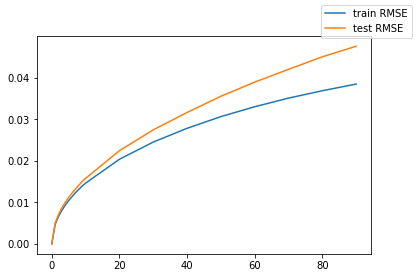

In [59]:
fig, ax = plt.subplots()
ax.plot(factors, train_rmse, label="train RMSE")
ax.plot(factors, test_rmse, label="test RMSE")
fig.legend()